Boost Converter Power Stage Transfer Function
============================================
***With Current-Mode Control in Continuous Conduction Mode***


# Table of Contents

- [Initializations](#Initializations)
- [Prerequisites](#Prerequisites)
- [Definitions](#Definitions)
- [Transfer_functions](#Transfer_functions)
  - [DC_gain](#DC_gain)
  - [Low-frequency_pole](#Low-frequency_pole)
  - [Output_capacitor_zero](#Output_capacitor_zero)
  - [Right_half_plane_zero](#Right_half_plane_zero)
  - [High-frequency_poles](#High-frequency_poles)
- [Control-to-output_transfer_function](#Control-to-output_transfer_function)
- [References](#References)

# Initializations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control as ct

import warnings
warnings.filterwarnings('ignore')

# Prerequisites

Boost converter with current mode control.

# Definitions

In [2]:
V_IN = 3.3                        # [V], input voltage
V_OUT = 5                         # [V], output voltage
M = V_OUT/V_IN                    # Conversion ratio
I_LOAD = 1                        # [A], load current
R_LOAD = V_OUT/I_LOAD             # [Ω], load resistance
F_SW = 100e3                      # [Hz], switch frequency
T_SW = 1/F_SW                     # [s], switch period
D = 1-V_IN/V_OUT                  # Steady-state duty cycle

# COMPONENTS
L = 10e-6                         # [H], switch inductor inductance
C_OUT = 47e-6                     # [F], output capacitor capacitance
R_C = 10e-3                       # [Ω], output capacitor ESR
R_SENSE = 0.1                     # [Ω], switch current sense reistance

# SLOPE COMPENSATION
S_N = V_IN/L*R_SENSE              # Inductor current slope during on-time
S_E = 0                           # External slope compensation
m_C = 1 + S_E/S_N                 # Slope compensation factor

# INFO
print("Conversion ratio M = {0:1.3g}".format(M))
print("Load resistance R_LOAD = {0:1.3g} Ω".format(R_LOAD))
print("Duty cycle D = {0:1.3g}".format(D))
L_critical = (1-V_IN/V_OUT)*V_IN*V_IN*R_LOAD / (2*F_SW*V_OUT*V_OUT)
print("Critical inductance = {0:1.3g} µH".format(L_critical*1e6))

Conversion ratio M = 1.52
Load resistance R_LOAD = 5 Ω
Duty cycle D = 0.34
Critical inductance = 3.7 µH


# Transfer_functions

In [3]:
s = ct.tf('s')

## DC_gain

From [SLVA636]:
$$H_{DC} = \frac{R_{LOAD}}{R_{SENSE}}(1-D)$$

From [BassoSwichtMode2]:
$$H_{DC} = \frac{R_{LOAD}}{R_{SENSE}} \frac{1}{2M + \frac{R_{LOAD}T_{SW}}{LM^2} \left(  \frac{1}{2} + \frac{S_E}{S_N} \right)} $$

In [4]:
H_DC_APPROX = (1-D)*R_LOAD / R_SENSE
H_DC = R_LOAD/R_SENSE * 1 / (2*M + R_LOAD*T_SW / (L*M*M) * (1/2 + S_E/S_N) )
print("H_DC_APPROX = {0:1.3g} dB".format(20*np.log10(H_DC_APPROX)))
print("H_DC = {0:1.3g} dB".format(20*np.log10(H_DC)))

H_DC_APPROX = 30.4 dB
H_DC = 21.7 dB


## Low-frequency_pole
Transfer function:

$$ H_p(s) = \frac{1}{1 + \frac{s}{\omega_p}}$$

Low frequency dominant pole,

from [SLVA636]:

$$ \omega_p = \frac{2}{R_{LOAD} C_{OUT}}$$

from [BassoSwichtMode2]:

$$ \omega_p = \frac{\frac{2}{R_LOAD} + \frac{T_{SW}}{LM^3} \left( 1 + \frac{S_E}{S_N} \right) } {C_{OUT}} $$

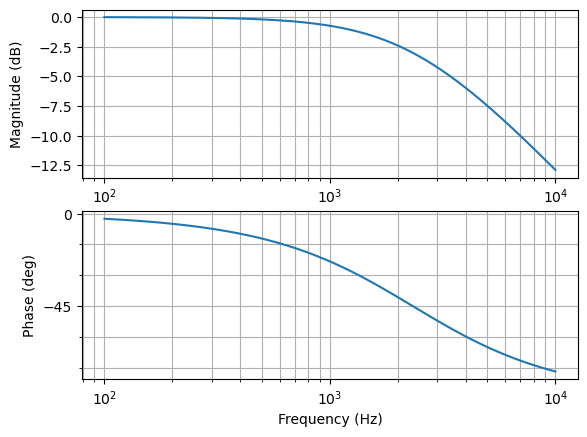

In [5]:
omega_p_approx = 2 / (R_LOAD*C_OUT)
omega_p = (2/R_LOAD + T_SW/(L*M*M*M)*(1+S_E/S_N) )/C_OUT
H_p = 1 / (1 + s/omega_p) 
Gmag, Gphase, Gomega = ct.bode_plot(H_p, dB = True, Hz = True)

In [6]:
print("f_p_approx = {0:1.3g} Hz".format(1/(2*np.pi) * omega_p_approx))
print("f_p = {0:1.3g} Hz".format(1/(2*np.pi) * omega_p))

f_p_approx = 1.35e+03 Hz
f_p = 2.33e+03 Hz


## Output_capacitor_zero

Transfer function:

$$ H_z(s) = 1 + \frac{s}{\omega_z}$$

Output capacitor zero:

$$ \omega_z = \frac{1}{R_C C_{OUT}}$$

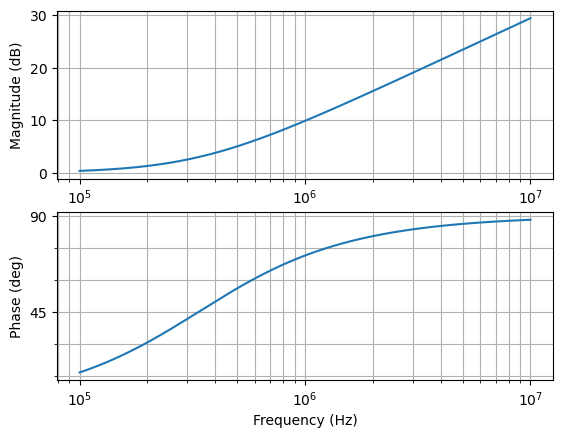

In [7]:
omega_Z = 1 / (R_C * C_OUT)
H_z = 1 + s/omega_Z
Gmag, Gphase, Gomega = ct.bode_plot(H_z, dB = True, Hz = True, wrap_phase = True)

In [8]:
print("f_Z = {0:1.3g} Hz".format(1/(2*np.pi) * omega_Z))

f_Z = 3.39e+05 Hz


## Right_half_plane_zero

Transfer function:

$$ H_{rhpz}(s) = 1 - \frac{s}{\omega_{rhpz}}$$

Right half plane zero:

$$ \omega_{rhpz} = \frac{R_{LOAD}(1-D)^2}{L} $$

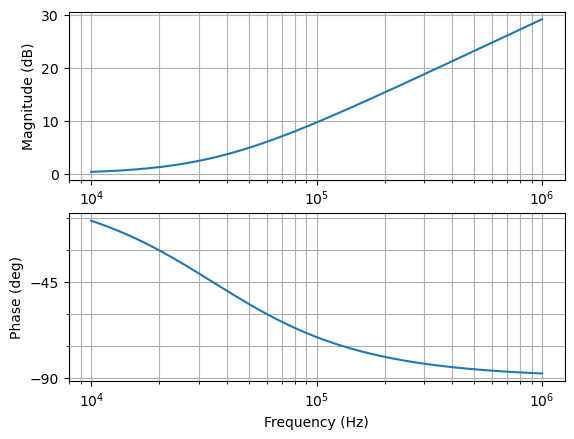

In [9]:
omega_rhpz = R_LOAD*(1-D)*(1-D) / L
H_rhpz = 1 - s/omega_rhpz
Gmag, Gphase, Gomega = ct.bode_plot(H_rhpz, dB = True, Hz = True)

In [10]:
print("f_rhpz = {0:1.3g} Hz".format(1/(2*np.pi) * omega_rhpz))

f_rhpz = 3.47e+04 Hz


## High-frequency_poles

To account for the oscillation in current-mode systems.

Transfer function:

$$ H_h(s) = \frac{1}{1 + \frac{s}{\omega_n Q_P} + (\frac{s}{\omega_n})^2} $$

Double pole (located at the half switch frequency):

$$ \omega_n = \pi F_{SW}$$

Quality factor:

$$ Q_P = \frac{1}{\pi \left( m_C(1-D) - 0.5 \right)}$$

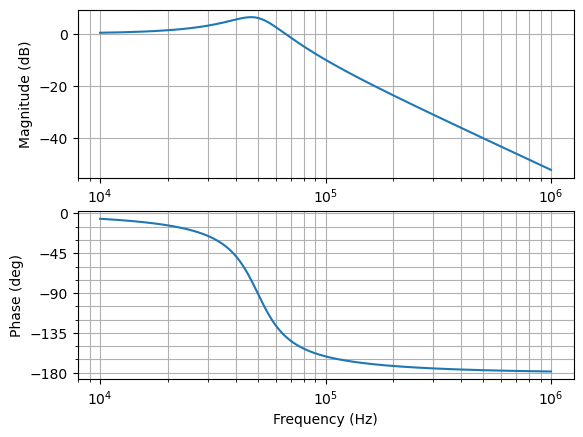

In [11]:
Q_p = 1 / (np.pi*(m_C*(1-D) - 0.5))
omega_n = np.pi*F_SW
H_h = 1 / (1 + s/(omega_n*Q_p) + (s/omega_n)*(s/omega_n))
Gmag, Gphase, Gomega = ct.bode_plot(H_h, dB = True, Hz = True, wrap_phase = True)

In [12]:
print("f_n = {0:1.3g} Hz".format(1/(2*np.pi) * omega_n))
print("Q_p = {0:1.3g}".format(Q_p))

f_n = 5e+04 Hz
Q_p = 1.99


# Control-to-output_transfer_function

Plant transfer function:

$$ H(s) = H_{DC}(s) H_p(s) H_z(s) H_{rhpz}(s) H_h(s) $$

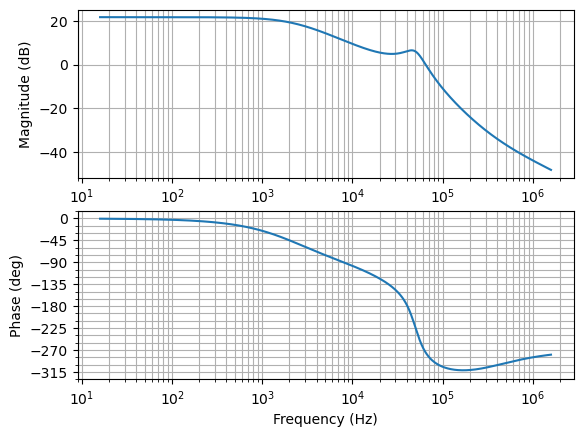

In [13]:
H = H_DC*H_p*H_z*H_rhpz*H_h
Gmag, Gphase, Gomega = ct.bode_plot(H, dB = True, Hz = True, omega_limits = [1e2, 1e7])

# References
[SLVA636] "Practical Feedback Loop Analysis for Current-Mode Boost Converter", SW Lee, Texas Instruments, March 2014

[BassoSwichtMode2] “Switch-mode Power Supplies – Spice Simulations and Practical Designs”, Basso, Christophe, 2nd ED, 2014

[Control] "Python Control Systems Library", https://python-control.readthedocs.io/en/0.9.4/
